In [14]:
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
file_path = '../../data/TSLA/RawData/extended_intraday_TSLA_1min_year1month10_adjusted.csv'

In [4]:
data = pd.read_csv(file_path)

In [5]:
time_col = pd.DatetimeIndex(data.time).tz_localize('US/Eastern')
data.time = time_col
data.set_index('time', inplace = True)

In [6]:
data.head()

,open,high,low,close,volume
time,,,,,
2020-04-23 20:00:00-04:00,139.550,139.552,139.384,139.384,8430
2020-04-23 19:59:00-04:00,139.470,139.500,139.470,139.500,3595
2020-04-23 19:58:00-04:00,139.212,139.288,139.212,139.288,8910
2020-04-23 19:57:00-04:00,139.208,139.300,139.200,139.200,5495
2020-04-23 19:56:00-04:00,139.500,139.500,139.206,139.206,10910


### Volitility Analysis
* Volatility defined as: $(\sum High - Low)/n$
* Applying a rolling mean window of size __10 seconds__

In [8]:
time_wdw = '10s'

data['diff'] = data.high - data.low
vol = data['diff'].rolling(time_wdw).mean()
data = data.assign(volatility=vol)
data.head()

,open,high,low,close,volume,diff,volatility
time,,,,,,,
2020-04-23 20:00:00-04:00,139.550,139.552,139.384,139.384,8430,0.168,0.168
2020-04-23 19:59:00-04:00,139.470,139.500,139.470,139.500,3595,0.030,0.030
2020-04-23 19:58:00-04:00,139.212,139.288,139.212,139.288,8910,0.076,0.076
2020-04-23 19:57:00-04:00,139.208,139.300,139.200,139.200,5495,0.100,0.100
2020-04-23 19:56:00-04:00,139.500,139.500,139.206,139.206,10910,0.294,0.294


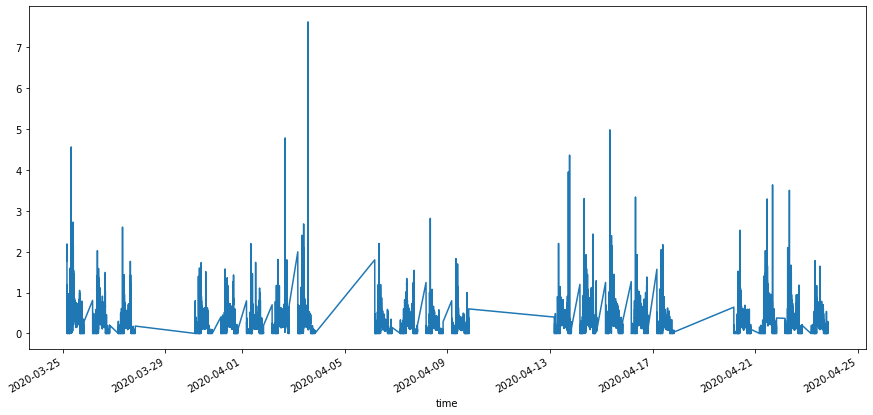

In [10]:
data.volatility.plot(figsize=(15,7))

In [11]:
data.reset_index(inplace=True)

In [12]:
data.shape

(15568, 8)

### Filter out data to use volatility on data an hour prior to market open
* Market Open: NYSE open Monday-Friday 9:30am to 4pm. Eastern time.

In [16]:
data = data.loc[data.time.apply(lambda date:(date.time()<=dt.time(hour=9, minute=30))
                        and (date.time()>=dt.time(hour=8, minute=30))
                        )]

In [17]:
data = data.set_index('time')

In [18]:
data.head()

,open,high,low,close,volume,diff,volatility
time,,,,,,,
2020-04-23 09:30:00-04:00,145.25600,145.37400,145.25600,145.37400,43270,0.118,0.118
2020-04-23 09:29:00-04:00,146.33800,146.33800,145.20000,145.20000,45200,1.138,1.138
2020-04-23 09:24:00-04:00,146.44992,146.44992,146.44992,146.44992,3720,0.000,0.000
2020-04-23 09:23:00-04:00,146.36000,146.45000,146.34200,146.45000,19410,0.108,0.108
2020-04-23 09:22:00-04:00,146.30000,146.30000,146.30000,146.30000,3600,0.000,0.000


### Change dataframe format to suit GramianAngularField
Now, we have to create a new dataframe that suits as a proper input to GramianAngularField. In order to do so, we have to create a dataframe where
* We only have volatility (and date) data.
* Each row corresponds to each date.
* Each row has same number of columns with __no null values__.

In order to do this, we first have to check how many data points are available for each date.

In [21]:
### add a "date" column
data['date'] = data.index.date
data.head()

,open,high,low,close,volume,diff,volatility,date
time,,,,,,,,
2020-04-23 09:30:00-04:00,145.25600,145.37400,145.25600,145.37400,43270,0.118,0.118,2020-04-23
2020-04-23 09:29:00-04:00,146.33800,146.33800,145.20000,145.20000,45200,1.138,1.138,2020-04-23
2020-04-23 09:24:00-04:00,146.44992,146.44992,146.44992,146.44992,3720,0.000,0.000,2020-04-23
2020-04-23 09:23:00-04:00,146.36000,146.45000,146.34200,146.45000,19410,0.108,0.108,2020-04-23
2020-04-23 09:22:00-04:00,146.30000,146.30000,146.30000,146.30000,3600,0.000,0.000,2020-04-23


In [36]:
### How many data points are availiable in the hour hour prior to market open each day?
data.groupby('date')['volatility'].count().head()

date
2020-03-25    61
2020-03-26    61
2020-03-27    58
2020-03-30    51
2020-03-31    57
Name: volatility, dtype: int64

To avoid null values in the final output, we calculate the minimum number out of these.

In [38]:
data_pts = data.groupby('date')['volatility'].count().min()
data_pts

51

Finally, we convert out data to a new dataframe whose numer of rows is the number of available dates, and whose number of columns is the maximum number of available data points prior to market open for all the dates.

In [49]:
new_df = data.groupby('date', as_index=True)['volatility'].apply(list)
new_df = pd.DataFrame(new_df)
new_df = pd.DataFrame(new_df['volatility'].apply(lambda lst: lst[:data_pts]))
new_df = pd.DataFrame(new_df['volatility'].to_list(), index=new_df.index)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2020-03-25,0.280,1.256,0.39598,0.798,0.168,0.250,0.352,0.060,0.082,0.29400,...,0.1160,0.196,0.258,0.19804,0.158,0.12600,0.332,0.202,0.1760,0.540
2020-03-26,0.100,0.840,0.38000,0.012,0.400,0.414,0.550,0.180,0.300,0.35436,...,0.1680,0.336,0.076,0.80000,0.476,0.29204,0.360,0.200,0.5800,0.294
2020-03-27,0.198,0.266,0.00000,0.020,0.202,0.090,0.400,0.032,0.200,0.20000,...,0.0900,0.180,0.090,0.29800,0.132,0.09600,0.178,0.016,0.3980,0.012
2020-03-30,0.208,1.406,0.00000,0.208,0.100,0.120,0.128,0.100,0.328,0.00000,...,0.1564,0.064,0.017,0.00000,0.200,0.21600,0.116,0.046,0.0054,0.000
2020-03-31,0.108,0.510,0.08200,0.060,0.294,0.044,0.000,0.000,0.000,0.03000,...,0.0940,0.194,0.006,0.00200,0.100,0.10000,0.240,0.000,0.2000,0.628


In [50]:
data.to_csv('data_vol_.csv')